In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import requests
from io import StringIO

In [72]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
ABBInput = '/content/drive/MyDrive/CPP-CSS/Stock_Market_Predictor/Datasets/Input/ABBInput.csv'
df = pd.read_csv(ABBInput)

# Long Short Term Memory (LSTM)

In [75]:
x = df.select_dtypes(include=[np.number])
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df[x.columns] = pd.DataFrame(x_scaled)
df.head()

,Date_shifted_by_1,Open_shifted_by_1,High_shifted_by_1,Low_shifted_by_1,Close_shifted_by_1,Adj Close_shifted_by_1,Volume_shifted_by_1,SMA_5_shifted_by_1,SMA_10_shifted_by_1,SMA_20_shifted_by_1,SMA_50_shifted_by_1,SMA_100_shifted_by_1,SMA_200_shifted_by_1,BollingerBand_Up_20_2_shifted_by_1,BollingerBand_Down_20_2_shifted_by_1,BollingerBand_Up_20_1_shifted_by_1,BollingerBand_Down_20_1_shifted_by_1,BollingerBand_Up_10_1_shifted_by_1,BollingerBand_Down_10_1_shifted_by_1,BollingerBand_Up_10_2_shifted_by_1,BollingerBand_Down_10_2_shifted_by_1,Donchian_Channel_Up_5_shifted_by_1,Donchian_Channel_Down_5_shifted_by_1,Donchian_Channel_Up_10_shifted_by_1,Donchian_Channel_Down_10_shifted_by_1,Donchian_Channel_Up_20_shifted_by_1,Donchian_Channel_Down_20_shifted_by_1,Donchian_Channel_Up_50_shifted_by_1,Donchian_Channel_Down_50_shifted_by_1,Donchian_Channel_Up_100_shifted_by_1,Donchian_Channel_Down_100_shifted_by_1,Donchian_Channel_Up_200_shifted_by_1,Donchian_Channel_Down_200_shifted_by_1,Date_shifted_by_2,Open_shifted_by_2,High_shifted_by_2,Low_shifted_by_2,Close_shifted_by_2,Adj Close_shifted_by_2,Volume_shifted_by_2,...,Donchian_Channel_Up_50_shifted_by_9,Donchian_Channel_Down_50_shifted_by_9,Donchian_Channel_Up_100_shifted_by_9,Donchian_Channel_Down_100_shifted_by_9,Donchian_Channel_Up_200_shifted_by_9,Donchian_Channel_Down_200_shifted_by_9,Date_shifted_by_10,Open_shifted_by_10,High_shifted_by_10,Low_shifted_by_10,Close_shifted_by_10,Adj Close_shifted_by_10,Volume_shifted_by_10,SMA_5_shifted_by_10,SMA_10_shifted_by_10,SMA_20_shifted_by_10,SMA_50_shifted_by_10,SMA_100_shifted_by_10,SMA_200_shifted_by_10,BollingerBand_Up_20_2_shifted_by_10,BollingerBand_Down_20_2_shifted_by_10,BollingerBand_Up_20_1_shifted_by_10,BollingerBand_Down_20_1_shifted_by_10,BollingerBand_Up_10_1_shifted_by_10,BollingerBand_Down_10_1_shifted_by_10,BollingerBand_Up_10_2_shifted_by_10,BollingerBand_Down_10_2_shifted_by_10,Donchian_Channel_Up_5_shifted_by_10,Donchian_Channel_Down_5_shifted_by_10,Donchian_Channel_Up_10_shifted_by_10,Donchian_Channel_Down_10_shifted_by_10,Donchian_Channel_Up_20_shifted_by_10,Donchian_Channel_Down_20_shifted_by_10,Donchian_Channel_Up_50_shifted_by_10,Donchian_Channel_Down_50_shifted_by_10,Donchian_Channel_Up_100_shifted_by_10,Donchian_Channel_Down_100_shifted_by_10,Donchian_Channel_Up_200_shifted_by_10,Donchian_Channel_Down_200_shifted_by_10,target
0,2002-02-08,0.218867,0.217594,0.219282,0.217856,0.115197,0.000589,0.217433,0.232170,0.247861,0.261281,0.247878,0.359611,0.272866,0.226621,0.262133,0.233923,0.250847,0.221149,0.263234,0.219991,0.220524,0.212219,0.264139,0.212766,0.269393,0.221106,0.27975,0.239826,0.270017,0.205931,0.507335,0.231803,2002-02-07,0.212017,0.223189,0.217391,0.225086,0.119021,0.000770,...,0.283695,0.294331,0.270017,0.214961,0.507335,0.231803,2002-01-28,0.277397,0.276034,0.274102,0.276957,0.148800,0.003488,0.268676,0.275403,0.276138,0.277100,0.253017,0.375658,0.274461,0.280699,0.276953,0.275374,0.281629,0.276289,0.281228,0.286033,0.27355,0.260450,0.288784,0.261122,0.280428,0.271357,0.283695,0.295728,0.270017,0.214961,0.507335,0.231803,0.192078
1,2002-02-11,0.219801,0.220081,0.222117,0.222572,0.117691,0.001161,0.217051,0.226642,0.243780,0.259365,0.247950,0.357687,0.267026,0.224513,0.257128,0.230823,0.240244,0.220735,0.247948,0.224554,0.220524,0.212219,0.257820,0.212766,0.269393,0.221106,0.27975,0.239826,0.270017,0.205931,0.507335,0.231803,2002-02-08,0.218867,0.217594,0.219282,0.217856,0.115197,0.000589,...,0.283695,0.279433,0.270017,0.214961,0.507335,0.231803,2002-01-29,0.271171,0.269817,0.271582,0.270670,0.145422,0.000247,0.269311,0.273006,0.276660,0.276714,0.252541,0.374244,0.273759,0.282441,0.276853,0.276516,0.277693,0.275453,0.275887,0.286723,0.27355,0.260450,0.272670,0.261122,0.280428,0.271357,0.283695,0.295728,0.270017,0.214961,0.507335,0.231803,0.188934
2,2002-02-12,0.219801,0.226298,0.223062,0.231374,0.122345,0.000279,0.221120,0.222648,0.240515,0.257898,0.248522,0.355981,0.261239,0.223958,0.252555,0.228915,0.2

In [76]:
df.reset_index(inplace=True, drop=True)
df = df.dropna()
print(df.dtypes)
#df.head()

Date_shifted_by_1                           object
Open_shifted_by_1                          float64
High_shifted_by_1                          float64
Low_shifted_by_1                           float64
Close_shifted_by_1                         float64
                                            ...   
Donchian_Channel_Up_100_shifted_by_10      float64
Donchian_Channel_Down_100_shifted_by_10    float64
Donchian_Channel_Up_200_shifted_by_10      float64
Donchian_Channel_Down_200_shifted_by_10    float64
target                                     float64
Length: 331, dtype: object


In [77]:
X = df.drop("target",axis=1)
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [78]:
correlations = np.abs(X_train.corrwith(y_train))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
X_train = X_train[features]
X_test = X_test[features]

In [87]:
columns = []
for shift in [1,2,3,4,5,6,7,8,9,10]:
    columns.append(str.format("Date_shifted_by_%d" % shift))
columns.append('target')
print(columns)

['Date_shifted_by_1', 'Date_shifted_by_2', 'Date_shifted_by_3', 'Date_shifted_by_4', 'Date_shifted_by_5', 'Date_shifted_by_6', 'Date_shifted_by_7', 'Date_shifted_by_8', 'Date_shifted_by_9', 'Date_shifted_by_10', 'target']


In [88]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=columns)
for i in range(0,len(data)):
    new_data['Date_shifted_by_1'][i] = data['Date_shifted_by_1'][i]
    new_data['target'][i] = data['target'][i]

#setting index
new_data.index = new_data.Date_shifted_by_1
for shift in [1,2,3,4,5,6,7,8,9,10]:
  new_data.drop(str.format('Date_shifted_by_%d' % shift), axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:2200,:]
valid = dataset[2200:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [91]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM

#read the file
#df = pd.read_csv('D:/CPP-CSS/Stock_Market_Predictor/NSE-TATAGLOBAL11.csv')
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/50
17/17 - 7s - loss: 0.0465
Epoch 2/50
17/17 - 3s - loss: 0.0023
Epoch 3/50
17/17 - 3s - loss: 7.3812e-04
Epoch 4/50
17/17 - 3s - loss: 4.6746e-04
Epoch 5/50
17/17 - 3s - loss: 4.4959e-04
Epoch 6/50
17/17 - 3s - loss: 4.2478e-04
Epoch 7/50
17/17 - 3s - loss: 4.3631e-04
Epoch 8/50
17/17 - 3s - loss: 4.8966e-04
Epoch 9/50
17/17 - 3s - loss: 4.3292e-04
Epoch 10/50
17/17 - 3s - loss: 4.4780e-04
Epoch 11/50
17/17 - 3s - loss: 4.0883e-04
Epoch 12/50
17/17 - 3s - loss: 3.8129e-04
Epoch 13/50
17/17 - 3s - loss: 3.6573e-04
Epoch 14/50
17/17 - 3s - loss: 3.5236e-04
Epoch 15/50
17/17 - 3s - loss: 3.5743e-04
Epoch 16/50
17/17 - 3s - loss: 4.1412e-04
Epoch 17/50
17/17 - 3s - loss: 3.6556e-04
Epoch 18/50
17/17 - 3s - loss: 3.4246e-04
Epoch 19/50
17/17 - 3s - loss: 3.3146e-04
Epoch 20/50
17/17 - 3s - loss: 3.3979e-04
Epoch 21/50
17/17 - 3s - loss: 3.2863e-04
Epoch 22/50
17/17 - 3s - loss: 3.4792e-04
Epoch 23/50
17/17 - 3s - loss: 3.3827e-04
Epoch 24/50
17/17 - 3s - loss: 3.4740e-04
Epoch 25/

In [92]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.013005050516830425

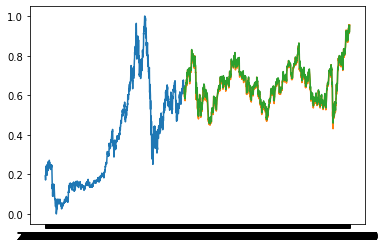

In [95]:
#for plotting
train = new_data[:2200]
valid = new_data[2200:]
valid['Predictions'] = closing_price
plt.plot(train['target'])
plt.plot(valid[['target','Predictions']])